In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

import DGM

# Deep Galerkin Method Solutions of the 2D Wave Equation

An extension of **DGM: A deep learning algorithm for solving partial diﬀerential equations** 

<br>

Bilal Saleh Husain, 2024-25

<br>

### Equation, Simulation, & DGM Parameters

In [2]:
# Domain parameters
r_min = 0         # Left boundary (fixed end)
r_max = 10.0      # Right boundary (fixed end)
T = 10.0          # Total simulation time
c = 1.0           # Wave speed (set to 1 for simplicity)

# Network parameters
layer_width = 50   # Neurons per hidden layer
n_layers = 3       # Number of LSTM layers

# Training parameters
sampling_stages = 15000
steps_per_sample = 1
learning_rate = 0.0001
nSim_interior = 5000    # Collocation points for PDE
nSim_IC = 5000          # Initial condition points
nSim_BC = 1000          # Boundary condition points

### Initial Conditions and Exact Solutions

In [3]:
def initial_condition(xy_tensor):
    # Parameters matching MATLAB
    L = r_max - r_min           # Domain size 
    x0 = L/2                    # Center x
    y0 = L/2                    # Center y
    amplitude = 2.0             # Peak amplitude 
    
    # Extract coordinates
    x = xy_tensor[:, 0:1]  # Shape [N,1]
    y = xy_tensor[:, 1:2]  # Shape [N,1]
    
    # Equivalent 2D Gaussian
    r_squared = (x - x0)**2 + (y - y0)**2
    gaussian = amplitude * torch.exp(-2 * r_squared)  
    
    return gaussian  # Shape [N,1]

### Sampler & Loss Function

In [7]:
def sampler(nSim_interior, nSim_IC, nSim_BC):

    # Interior point sampling
    t_interior = np.random.uniform(0, T, (nSim_interior, 1))
    r_interior = np.random.uniform(r_min, r_max, (nSim_interior, 2))

    # Initial condition sampling
    t_IC = np.zeros((nSim_IC, 1))
    xy_IC = np.random.uniform(r_min, r_max, (nSim_IC, 2))

    # Boundary condition sampling
    t_BC = np.random.uniform(0, T, (nSim_BC, 1))
    t_BC = np.vstack([t_BC, t_BC, t_BC, t_BC])
    
    #xy_BC = np.random.choice([r_min, r_max], (nSim_BC, 2))
    
    r_random = np.random.uniform(r_min, r_max, (nSim_BC, 1))                 # Generate random r_i ∈ [r_min, r_max]
    xy_BC_1 = np.column_stack([r_random, np.full((nSim_BC, 1), r_min)])      # Create pairs (r_i, r_min)
    
    r_random = np.random.uniform(r_min, r_max, (nSim_BC, 1))                 # Generate random r_i ∈ [r_min, r_max]
    xy_BC_2 = np.column_stack([r_random, np.full((nSim_BC, 1), r_max)])      # Create pairs (r_i, r_max)
    
    r_random = np.random.uniform(r_min, r_max, (nSim_BC, 1))                 # Generate random r_i ∈ [r_min, r_max]
    xy_BC_3 = np.column_stack([np.full((nSim_BC, 1), r_min), r_random])      # Create pairs (r_min, r0)

    r_random = np.random.uniform(r_min, r_max, (nSim_BC, 1))                 # Generate random r_i ∈ [r_min, r_max]
    xy_BC_4 = np.column_stack([np.full((nSim_BC, 1), r_max), r_random])      # Create pairs (r_max, r0)
                                 
    xy_BC = np.vstack([xy_BC_1, xy_BC_2, xy_BC_3, xy_BC_4])
    
    return (t_interior, r_interior), (t_IC, xy_IC), (t_BC, xy_BC)

In [8]:
def loss(model, t_interior, xy_interior, t_IC, xy_IC, t_BC, xy_BC):
    # PDE Loss (u_tt = u_xx + u_yy)
    xy_interior.requires_grad_(True)
    phi = model(t_interior, xy_interior)
    
    # First derivatives
    phi_t = torch.autograd.grad(phi.sum(), t_interior, create_graph=True)[0]
    phi_x = torch.autograd.grad(phi.sum(), xy_interior, create_graph=True)[0][:, 0:1]  # x-component
    phi_y = torch.autograd.grad(phi.sum(), xy_interior, create_graph=True)[0][:, 1:2]  # y-component
    
    # Second derivatives
    phi_tt = torch.autograd.grad(phi_t.sum(), t_interior, create_graph=True)[0]
    phi_xx = torch.autograd.grad(phi_x.sum(), xy_interior, create_graph=True)[0][:, 0:1]
    phi_yy = torch.autograd.grad(phi_y.sum(), xy_interior, create_graph=True)[0][:, 1:2]
    
    L_PDE = torch.mean((phi_tt - (phi_xx + phi_yy))**2)
    
    # Initial Conditions
    phi_IC = model(t_IC, xy_IC)
    phi0 = initial_condition(xy_IC) 
    
    # Initial velocity condition 
    t_IC.requires_grad_(True)
    phi_t_IC = torch.autograd.grad(phi_IC.sum(), t_IC, create_graph=True)[0]
    L_IC = torch.mean((phi_IC - phi0)**2 + phi_t_IC**2)
    
    # Boundary Conditions (Dirichlet: u=0)
    phi_BC = model(t_BC, xy_BC)
    L_BC = torch.mean(phi_BC**2)
    
    return L_PDE, L_IC, L_BC

### Model Training

In [9]:
model = DGM.DGMNet(layer_width, n_layers, input_dim=2)  # Changed to input_dim=2 for (x,y)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.5) 
iteration_counter = 0

for i in range(sampling_stages):
    # Get sampled points - returns concatenated spatial coordinates
    interior_points, IC_points, BC_points = sampler(nSim_interior, nSim_IC, nSim_BC)
    
    # Convert to tensors - spatial coordinates are now [N,2] tensors
    t_interior = torch.tensor(interior_points[0], dtype=torch.float32, requires_grad=True)
    xy_interior = torch.tensor(interior_points[1], dtype=torch.float32, requires_grad=True)  
    
    t_IC = torch.tensor(IC_points[0], dtype=torch.float32, requires_grad=True)
    xy_IC = torch.tensor(IC_points[1], dtype=torch.float32) 
    
    t_BC = torch.tensor(BC_points[0], dtype=torch.float32)
    xy_BC = torch.tensor(BC_points[1], dtype=torch.float32) 

    iteration_counter += 1

    for _ in range(steps_per_sample):
        optimizer.zero_grad()
        
        # Compute losses - using modified 2D loss function
        L_PDE, L_IC, L_BC = loss(model, t_interior, xy_interior, t_IC, xy_IC, t_BC, xy_BC)
        total_loss = L_PDE + L_IC + L_BC
        
        total_loss.backward()
        optimizer.step()

    scheduler.step()
    if iteration_counter % 1000 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\n↳ LR reduced to {current_lr:.1e} at iteration {iteration_counter}", '\n')

    
    print(f"Iter {i}, Loss: {total_loss.item():.2e}, "
          f"PDE: {L_PDE.item():.1e}, IC: {L_IC.item():.1e}, BC: {L_BC.item():.1e}")

Iter 0, Loss: 1.60e+01, PDE: 9.1e-01, IC: 8.6e+00, BC: 6.5e+00
Iter 1, Loss: 1.48e+01, PDE: 8.9e-01, IC: 7.7e+00, BC: 6.2e+00
Iter 2, Loss: 1.33e+01, PDE: 9.5e-01, IC: 6.9e+00, BC: 5.4e+00
Iter 3, Loss: 1.19e+01, PDE: 8.7e-01, IC: 6.1e+00, BC: 4.9e+00
Iter 4, Loss: 1.08e+01, PDE: 8.5e-01, IC: 5.5e+00, BC: 4.5e+00
Iter 5, Loss: 9.60e+00, PDE: 8.3e-01, IC: 4.9e+00, BC: 3.9e+00
Iter 6, Loss: 8.66e+00, PDE: 9.2e-01, IC: 4.1e+00, BC: 3.6e+00
Iter 7, Loss: 8.22e+00, PDE: 8.9e-01, IC: 3.9e+00, BC: 3.4e+00
Iter 8, Loss: 7.55e+00, PDE: 9.0e-01, IC: 3.5e+00, BC: 3.2e+00
Iter 9, Loss: 6.71e+00, PDE: 8.8e-01, IC: 3.1e+00, BC: 2.7e+00
Iter 10, Loss: 6.02e+00, PDE: 9.1e-01, IC: 2.7e+00, BC: 2.4e+00
Iter 11, Loss: 5.35e+00, PDE: 8.8e-01, IC: 2.4e+00, BC: 2.1e+00
Iter 12, Loss: 4.77e+00, PDE: 8.3e-01, IC: 2.0e+00, BC: 1.9e+00
Iter 13, Loss: 4.28e+00, PDE: 8.8e-01, IC: 1.8e+00, BC: 1.6e+00
Iter 14, Loss: 4.01e+00, PDE: 8.5e-01, IC: 1.6e+00, BC: 1.6e+00
Iter 15, Loss: 3.63e+00, PDE: 8.3e-01, IC: 1.4e+00

KeyboardInterrupt: 

### Plotting

In [10]:
tf = 5

# Set up spatial grid
x_vals = np.linspace(r_min, r_max, 50)
y_vals = np.linspace(r_min, r_max, 50)
X, Y = np.meshgrid(x_vals, y_vals)
t_vals = np.linspace(0, tf, 50)

# Create 3D figure
fig = plt.figure(figsize=(10, 7)) #, dpi=200)
ax = fig.add_subplot(111, projection='3d')

# Configure axes
ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.set_zlabel('Amplitude')

# Pre-compute neural network solutions
solutions_nn = []
with torch.no_grad():
    for t in t_vals:
        # Create input tensors
        t_tensor = torch.full((X.size, 1), t, dtype=torch.float32)
        xy_tensor = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
        
        # Get prediction and reshape
        phi_nn = model(t_tensor, xy_tensor).numpy().reshape(X.shape)
        solutions_nn.append(phi_nn)

# Initialize surface plot
surf = ax.plot_surface(X, Y, solutions_nn[0], cmap='viridis', rstride=1, cstride=1)
#fig.colorbar(surf, shrink=0.5, aspect=5)

# Animation function
def animate(i):
    ax.clear()
    surf = ax.plot_surface(X, Y, solutions_nn[i], cmap='viridis', 
                          rstride=1, cstride=1, vmin=-1, vmax=1)
    ax.set_zlim(-1, 1)
    ax.set_title(f't = {t_vals[i]:.2f}')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$\phi$')
    return fig,

# Create animation
ani = FuncAnimation(fig, animate, frames=len(t_vals), interval=100, blit=False)

# Display
plt.tight_layout()
plt.close()
HTML(ani.to_jshtml())

<>:43: SyntaxWarning: invalid escape sequence '\p'
<>:43: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71125/3962052917.py:43: SyntaxWarning: invalid escape sequence '\p'
  ax.set_zlabel('$\phi$')
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71125/3962052917.py:43: SyntaxWarning: invalid escape sequence '\p'
  ax.set_zlabel('$\phi$')


KeyboardInterrupt: 

### Crank-Nicolson Scheme

In [11]:
# Parameters
c = 1  # wave speed
r_min, r_max = 0, 10  # domain size
tf = 5  # final time
nx, ny, nt = 50, 50, 50  # grid points
A = 2 #


# Spatial grid
x_vals = np.linspace(r_min, r_max, nx)
y_vals = np.linspace(r_min, r_max, ny)
X, Y = np.meshgrid(x_vals, y_vals)
dx = x_vals[1] - x_vals[0]
dy = y_vals[1] - y_vals[0]
dt = tf / nt

# Crank-Nicolson parameters
alpha_x = (c * dt / dx)**2
alpha_y = (c * dt / dy)**2

# Initial condition
def gaussian_initial(x, y):
    L = r_max - r_min
    x0, y0 = L/2, L/2
    return A * np.exp(-2*((x-x0)**2 + (y-y0)**2))


# Initialize solution array
u = np.zeros((nt, ny, nx))
u[0] = gaussian_initial(X, Y)

# Second time step (zero initial velocity)
u[1] = u[0]

# Crank-Nicolson scheme for 2D wave equation
for n in range(1, nt-1):
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            u[n+1, i, j] = (2*u[n, i, j] - u[n-1, i, j] + 
                           alpha_x/2 * (u[n, i+1, j] - 2*u[n, i, j] + u[n, i-1, j]) +
                           alpha_y/2 * (u[n, i, j+1] - 2*u[n, i, j] + u[n, i, j-1]))
    
    # Boundary conditions (Dirichlet)
    u[n+1, 0, :] = 0
    u[n+1, -1, :] = 0
    u[n+1, :, 0] = 0
    u[n+1, :, -1] = 0

In [12]:
# Find global min/max for consistent coloring
global_min = min(np.min(solutions_nn), np.min(u))
global_max = max(np.max(solutions_nn), np.max(u))

# Create figure for comparison
fig = plt.figure(figsize=(20, 7))
t_vals = np.linspace(0, 4, nt)

# Subplot for Crank-Nicolson
ax1 = fig.add_subplot(121, projection='3d')
surf_cn = ax1.plot_surface(X, Y, u[0], cmap='viridis', 
                         vmin=global_min, vmax=global_max)
ax1.set_zlim(global_min, global_max)
ax1.set_title('Crank-Nicolson Solution')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$\phi$')

# Subplot for Neural Network
ax2 = fig.add_subplot(122, projection='3d')
surf_nn = ax2.plot_surface(X, Y, solutions_nn[0], cmap='viridis',
                         vmin=global_min, vmax=global_max)
ax2.set_zlim(global_min, global_max)
ax2.set_title('Neural Network Solution')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')

# Animation function
def animate(i):
    ax1.clear()
    ax2.clear()
    
    # Crank-Nicolson plot with fixed colors
    surf1 = ax1.plot_surface(X, Y, u[i], cmap='viridis',
                           vmin=global_min, vmax=global_max)
    ax1.set_zlim(global_min, global_max)
    ax1.set_title(f'Crank-Nicolson (t={t_vals[i]:.2f})')
    ax2.set_xlabel('$x_1$')
    ax2.set_ylabel('$x_2$')
    ax1.set_zlabel('$\phi$')
    ax2.set_zlabel('$\phi$')
    
    # Neural Network plot with fixed colors
    surf2 = ax2.plot_surface(X, Y, solutions_nn[i], cmap='viridis',
                           vmin=global_min, vmax=global_max)
    ax2.set_zlim(global_min, global_max)
    ax2.set_title(f'DGM Approximation (t={t_vals[i]:.2f})')
    ax2.set_xlabel('$x_1$')
    ax2.set_ylabel('$x_2$')
    
    return surf1, surf2

# Create animation
ani = FuncAnimation(fig, animate, frames=len(t_vals), interval=100, blit=False)

#ani.save('2D_Wave_Equation.gif', writer='pillow', fps=20, dpi=200)


plt.tight_layout()
plt.close()
HTML(ani.to_jshtml())

<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:41: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:41: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71125/460160707.py:17: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_zlabel('$\phi$')
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71125/460160707.py:40: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_zlabel('$\phi$')
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71125/460160707.py:41: SyntaxWarning: invalid escape sequence '\p'
  ax2.set_zlabel('$\phi$')
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71125/460160707.py:17: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_zlabel('$\phi$')
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71125/460160707.py:40: 

KeyboardInterrupt: 

<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_70256/2953124747.py:24: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_zlabel('$\phi$')
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_70256/2953124747.py:33: SyntaxWarning: invalid escape sequence '\p'
  ax2.set_zlabel('$\phi$')


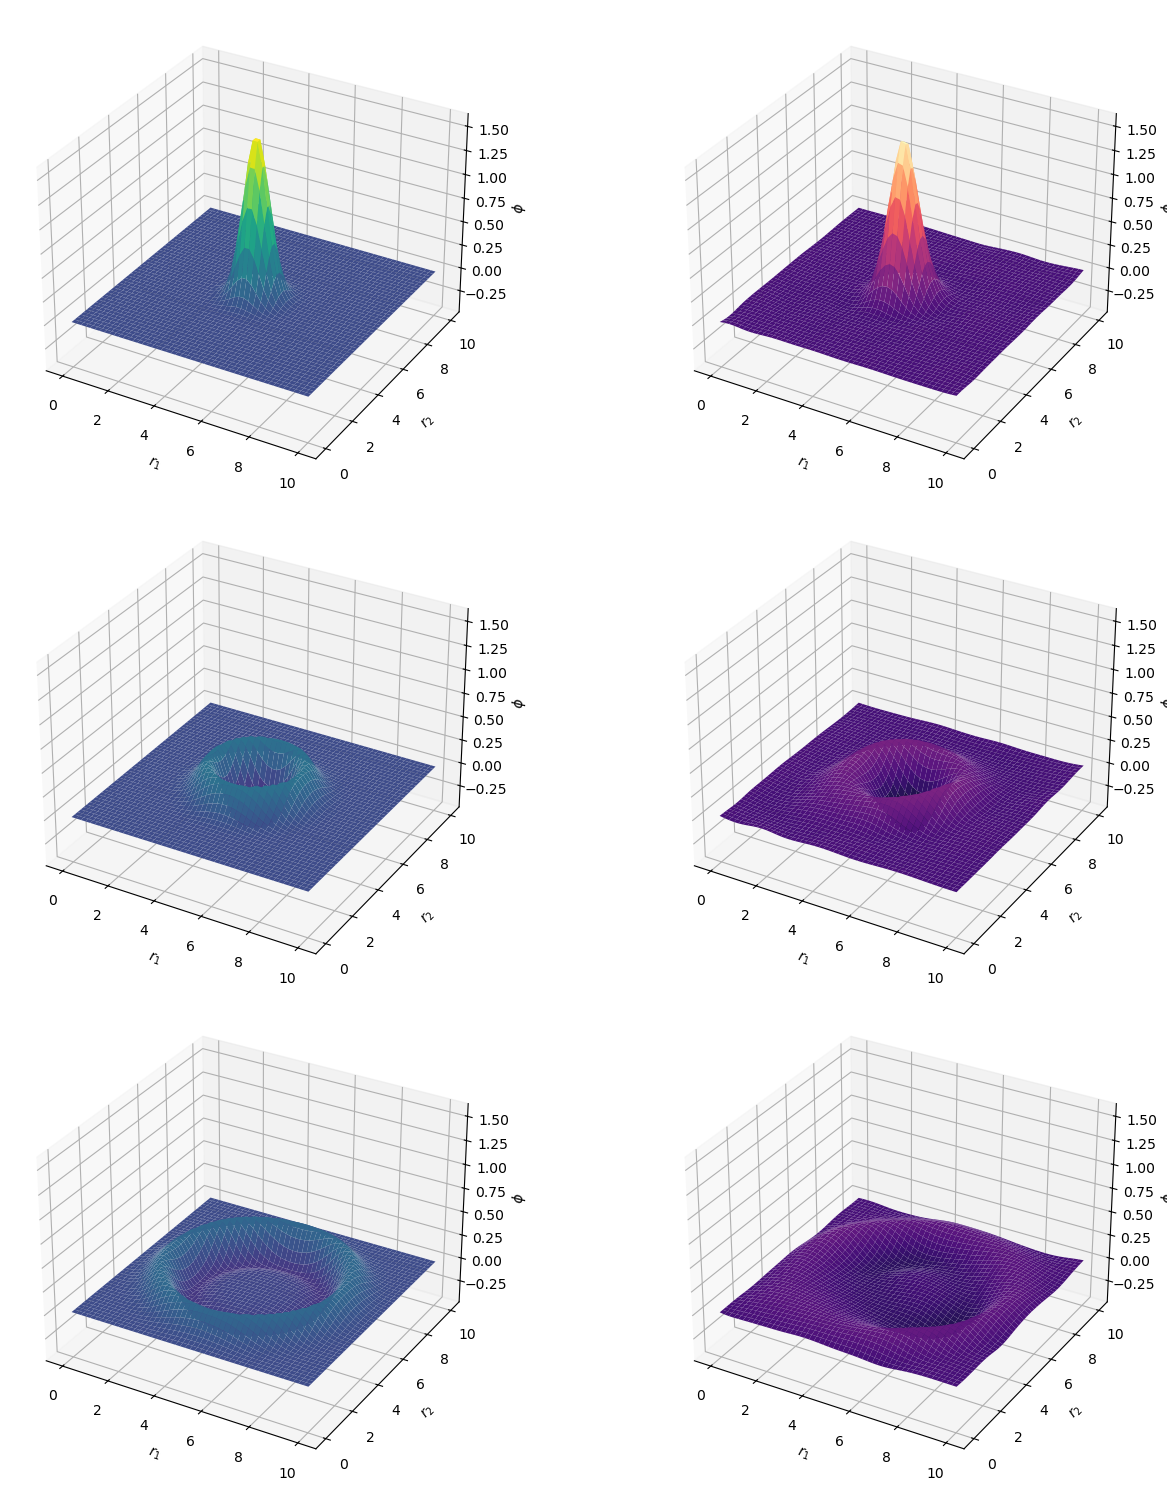

In [38]:
# Define the specific times you want to compare
selected_times = [0, 1.5, 3]  # Adjust these times as needed
n_times = len(selected_times)

# Find the closest time indices in your t_vals array
time_indices = [np.argmin(np.abs(t_vals - t)) for t in selected_times]

# Create figure with 3 rows and 2 columns
fig = plt.figure(figsize=(15, 15))

# Find global min/max for consistent coloring (same as before)
global_min = min(np.min(solutions_nn), np.min(u))
global_max = max(np.max(solutions_nn), np.max(u))

# Create subplots for each time point
for i, (idx, t) in enumerate(zip(time_indices, selected_times)):
    # Crank-Nicolson plot (left column)
    ax1 = fig.add_subplot(n_times, 2, 2*i+1, projection='3d')
    surf1 = ax1.plot_surface(X, Y, u[idx], cmap='viridis',
                          vmin=global_min, vmax=global_max)
    ax1.set_zlim(global_min, global_max)
    ax1.set_xlabel('$r_1$')
    ax1.set_ylabel('$r_2$')
    ax1.set_zlabel('$\phi$')
    
    # DGM plot (right column)
    ax2 = fig.add_subplot(n_times, 2, 2*i+2, projection='3d')
    surf2 = ax2.plot_surface(X, Y, solutions_nn[idx], cmap='magma',
                          vmin=global_min, vmax=global_max)
    ax2.set_zlim(global_min, global_max)
    ax2.set_xlabel('$r_1$')
    ax2.set_ylabel('$r_2$')
    ax2.set_zlabel('$\phi$')

plt.tight_layout()
fig.savefig('2D_Wave_Equation.png', dpi=300, facecolor='white')

plt.show()

### Model Saving

In [59]:
torch.save(model.state_dict(), '2D_ obbl_initial.pth')

# Load (requires architecture to be defined first)
#model = YourModelClass()  # Re-initialize the model
#model.load_state_dict(torch.load('weights.pth'))
#model.eval()

In [6]:
model = DGM.DGMNet(layer_width, n_layers, input_dim=2)  # Re-initialize the model
model.load_state_dict(torch.load('Saved Weights/2D_gaussian_MD_centered_initial.pth'))
model.eval()

/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_70256/912689810.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Saved Weight

DGMNet(
  (initial_layer): DenseLayer()
  (LSTMLayerList): ModuleList(
    (0-2): 3 x LSTMLayer()
  )
  (final_layer): DenseLayer()
)

In [ ]:
'''
Note: saved weights is for model with the following training parameters:

    "weight_sine_initial.pth"
    
        r_min = 0      
        r_max = 10.0       
        T = 10.0          
        c = 1.0          
        
        layer_width = 50  
        n_layers = 3       
        
        sampling_stages = 1000
        steps_per_sample = 20
        learning_rate = 0.0001
        nSim_interior = 1000   
        nSim_IC = 1000         
        nSim_BC = 1000         
    
        phi0 = sine_initial_condition(r_IC, r_max - r_min, n=3, A=0.5)

    "weight_gaussian_initial.pth"
    
'''